In [1]:
import numpy as np
import pandas as pd


In [2]:
df = pd.read_csv('/Users/mannes/thesis/correlation_evaluation/Qwen7B_math_run.csv')

# df = pd.read_csv('/Users/mannes/thesis/complex_task_gen/output/output/df_eval_daniil.csv')
df_corr = pd.read_csv('/Users/mannes/thesis/correlation_evaluation/correlation_table.csv')

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

# Assuming df_eval is your DataFrame
alphas = np.linspace(-1, 2, 301)
best_alpha, best_corr = None, -1

for alpha in alphas:
    df["score"] = df["logp_sum"] / (df["n_tokens"] ** alpha)
    rho, _ = spearmanr(df["score"], df["pass1_int"])  # assuming pass1_int is 1/0 pass label
    if abs(rho) > best_corr:
        best_alpha, best_corr = alpha, abs(rho)

print(f"Best alpha: {best_alpha:.3f}, correlation: {best_corr:.3f}")

Best alpha: 0.780, correlation: 0.288


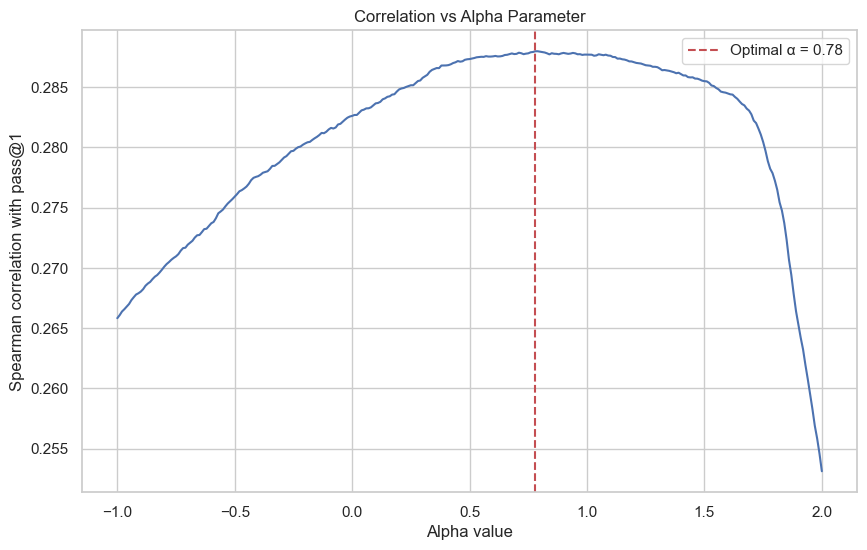

Summary statistics:
       Group  Count       Mean        Std        Min       Max
0    Correct   1245  -3.114596  11.651587 -59.887430 -0.038708
1  Incorrect     74 -36.710726  25.375077 -61.569716 -0.175323

T-test results: t-statistic = 11.3186, p-value = 0.00000000
The mean scores are statistically significantly different.


In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr, ttest_ind
sns.set_theme(style="whitegrid")
# Plot correlation vs alpha
alphas = np.linspace(-1, 2, 301)
correlations = []

for alpha in alphas:
    df["score"] = df["logp_sum"] / (df["n_tokens"] ** alpha)
    rho, _ = spearmanr(df["score"], df["pass1_int"])
    correlations.append(rho)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(alphas, correlations)
plt.axvline(x=best_alpha, color='r', linestyle='--', label=f'Optimal α = {best_alpha}')
plt.xlabel('Alpha value')
plt.ylabel('Spearman correlation with pass@1')
plt.title('Correlation vs Alpha Parameter')
plt.grid(True)
plt.legend()
plt.savefig('/Users/mannes/thesis/correlation_evaluation/alpha_vs_correlation_7b_base.png', dpi=300, bbox_inches='tight')
plt.show()
# Calculate scores with optimal alpha
df["score_optimal"] = df["logp_sum"] / (df["n_tokens"] ** best_alpha)

# Group by correct/incorrect
correct_scores = df[df["pass1_int"] == 1]["score_optimal"]
incorrect_scores = df[df["pass1_int"] == 0]["score_optimal"]

# Statistical summary
summary = pd.DataFrame({
    'Group': ['Correct', 'Incorrect'],
    'Count': [len(correct_scores), len(incorrect_scores)],
    'Mean': [correct_scores.mean(), incorrect_scores.mean()],
    'Std': [correct_scores.std(), incorrect_scores.std()],
    'Min': [correct_scores.min(), incorrect_scores.min()],
    'Max': [correct_scores.max(), incorrect_scores.max()]
})

print("Summary statistics:")
print(summary)

# Run t-test
t_stat, p_value = ttest_ind(correct_scores, incorrect_scores, equal_var=False)
print(f"\nT-test results: t-statistic = {t_stat:.4f}, p-value = {p_value:.8f}")
if p_value < 0.05:
    print("The mean scores are statistically significantly different.")


In [34]:
best_alpha, best_corr = None, -1
for alpha in alphas:
    df["score"] = df["logp_sum"] / (df["n_tokens"] ** alpha)
    rho, _ = spearmanr(df["score"], df["pass1_int"])
    if abs(rho) > best_corr:
        best_alpha, best_corr = alpha, abs(rho)

print(f"Best alpha: {best_alpha:.3f}, correlation: {best_corr:.3f}")

Best alpha: 0.780, correlation: 0.288


In [26]:
df["score_alpha"] = df["logp_sum"] / (df["n_tokens"] ** best_alpha)

from scipy.stats import pearsonr, spearmanr

spearman_corr = spearmanr(df["score_alpha"], df["pass1_int"])
pearson_corr = pearsonr(df["score_alpha"], df["pass1_int"])

print("Spearman:", spearman_corr.correlation, "p-value:", spearman_corr.pvalue)
print("Pearson:", pearson_corr.correlation, "p-value:", pearson_corr.pvalue)


Spearman: 0.287975030517845 p-value: 1.3222042169031477e-26
Pearson: 0.5171987493767741 p-value: 4.031467532375199e-91


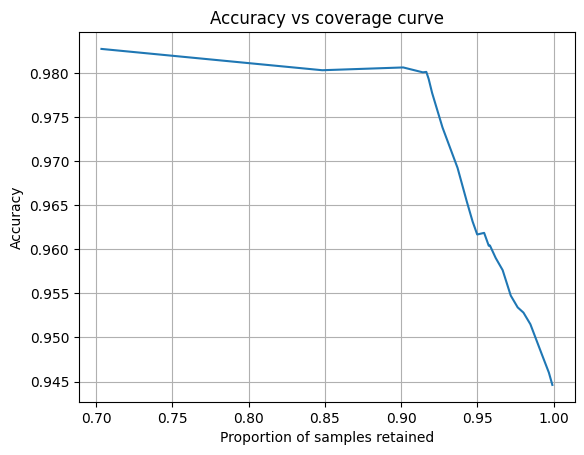

In [27]:
import matplotlib.pyplot as plt

thresholds = np.linspace(df["score_alpha"].min(), df["score_alpha"].max(), 100)
pass_rates = [(df["score_alpha"] > t).mean() for t in thresholds]
accuracies = [df[df["score_alpha"] > t]["pass1_int"].mean() for t in thresholds]

plt.plot(pass_rates, accuracies)
plt.xlabel("Proportion of samples retained")
plt.ylabel("Accuracy")
plt.title("Accuracy vs coverage curve")
plt.grid()
plt.show()


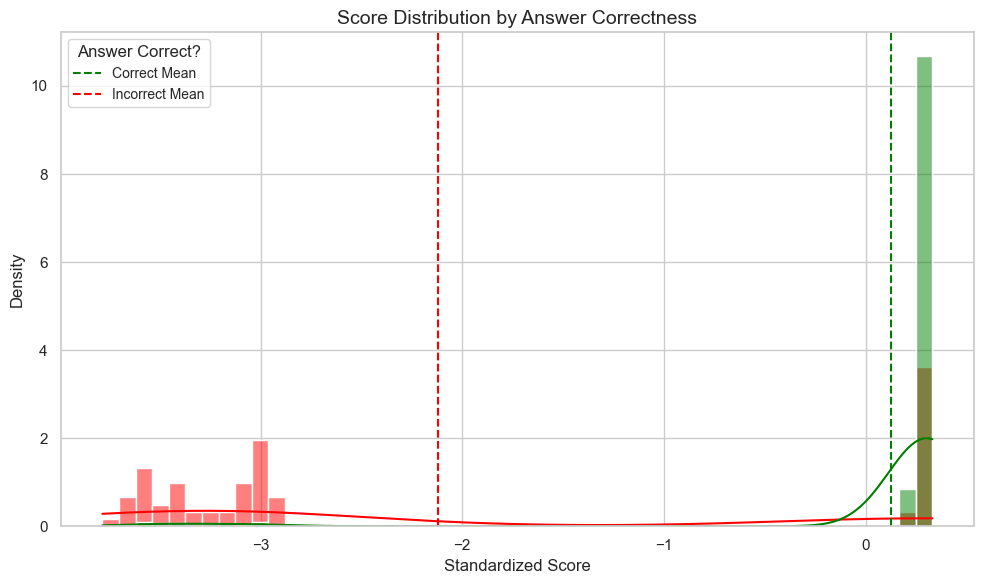

In [38]:
from sklearn.preprocessing import StandardScaler

# Prepare data
df["score_optimal"] = df["logp_sum"] / (df["n_tokens"] ** best_alpha)
df["label"] = df["pass1_int"].map({0: "Incorrect", 1: "Correct"})

# Normalize for better comparison
scaler = StandardScaler()
from sklearn.preprocessing import StandardScaler
df["score_optimal_scaled"] = StandardScaler().fit_transform(df[["score_optimal"]])

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="score_optimal_scaled", hue="label",
             kde=True, bins=50, stat="density", common_norm=False,
             palette={"Incorrect": "red", "Correct": "green"})

# Add mean lines
correct_mean = df[df["label"] == "Correct"]["score_optimal_scaled"].mean()
incorrect_mean = df[df["label"] == "Incorrect"]["score_optimal_scaled"].mean()
plt.axvline(correct_mean, color="green", linestyle="--", label="Correct Mean")
plt.axvline(incorrect_mean, color="red", linestyle="--", label="Incorrect Mean")

# Labels and layout
plt.title('Score Distribution by Answer Correctness', fontsize=14)
plt.xlabel('Standardized Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Answer Correct?', fontsize=10, title_fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/mannes/thesis/correlation_evaluation/score_distribution_7b.png')
plt.show()


In [39]:
df_corr

,metric,pearson,pearson_p,spearman,spearman_p
0,logp_sum,0.516285,9.437976e-91,0.282610,1.208571e-25
1,avg_logp,0.517499,3.047940e-91,0.287698,1.483921e-26
2,perplexity,-0.434175,9.264637e-62,-0.287698,1.483921e-26
3,token_entropy,-0.517709,2.505158e-91,-0.294776,7.460066e-28
4,prompt_len,-0.052414,5.702890e-02,-0.044514,1.061103e-01
5,num_ops,0.011676,6.718110e-01,0.007965,7.725686e-01
6,voting_entropy,-0.020369,4.598334e-01,-0.011980,6.637792e-01


In [ ]:
df

In [ ]:
# Run for 7B Model --> check that daniil is not insane
# Update novelty score